In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from PIL import Image
from utils import unify_coordinates_referential

data = pd.read_csv("../data/clean_data.csv")
data = unify_coordinates_referential(data)

In [25]:
# Filter data for the 2017 season and SJS team
sjs_data = data[(data['season'] == 2017) & (data['byTeam'] == 'SJS')]

# Filter data for the 2017 season for the entire league
league_data_2017 = data[data['season'] == 2017]

sjs_data.head()

,gameId,season,gameType,gameDate,homeTeam,awayTeam,rinkSide,period,periodTime,byTeam,eventType,shotType,coordinateX,coordinateY,shooterName,goalieName,strength,emptyNet
80606,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,00:33,SJS,SHOT,Backhand,-29.0,40.0,Mikkel Boedker,Brian Elliott,False,False
80607,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:05,SJS,SHOT,Slap Shot,28.0,-24.0,Brent Burns,Brian Elliott,False,False
80608,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,01:10,SJS,SHOT,Snap Shot,31.0,15.0,Brent Burns,Brian Elliott,False,False
80613,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,09:59,SJS,SHOT,Slap Shot,67.0,-34.0,Brent Burns,Brian Elliott,False,False
80614,2017020004,2017,R,2017-10-05,SJS,PHI,left,1,10:04,SJS,SHOT,Slap Shot,35.0,18.0,Dylan DeMelo,Brian Elliott,False,False


In [26]:
np.linspace(-100, 100, 101)
np.linspace(-42, 42, 85)

array([-42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32.,
       -31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.])

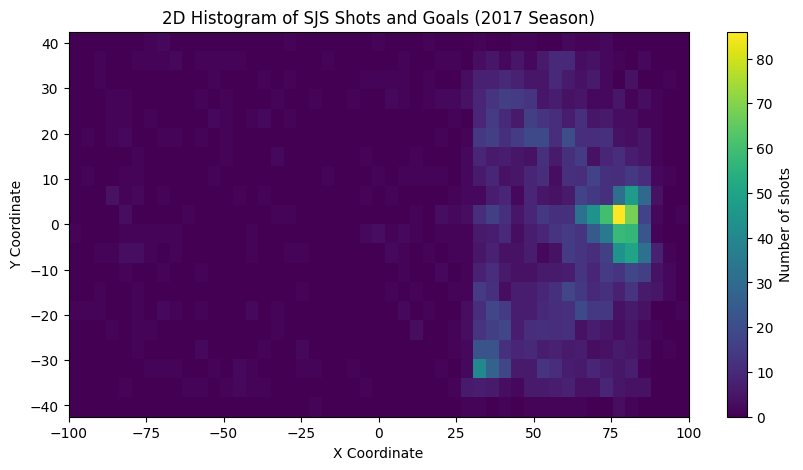

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins for histogram
x_bins = np.linspace(-100, 100, 50)
y_bins = np.linspace(-42.5, 42.5, 21)

# Create 2D histogram for SJS shots and goals
sjs_hist, x_edges, y_edges = np.histogram2d(sjs_data['coordinateX'], sjs_data['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, sjs_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of SJS Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

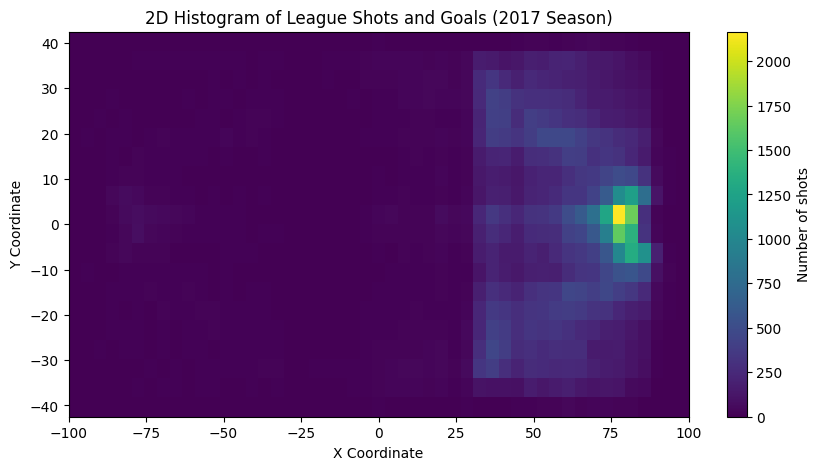

In [28]:
# Create 2D histogram for the entire league's shots and goals in 2017 season
league_hist, _, _ = np.histogram2d(league_data_2017['coordinateX'], league_data_2017['coordinateY'], bins=[x_bins, y_bins])

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, league_hist.T, shading='auto', cmap='viridis')
plt.colorbar(label='Number of shots')
plt.title('2D Histogram of League Shots and Goals (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [29]:
# Determine the number of games played by SJS in 2017
sjs_games_played = sjs_data['gameId'].nunique()

# Determine the total number of games in the league in 2017
total_league_games = league_data_2017['gameId'].nunique()

# Compute per-hour averages for histograms
sjs_hist_per_hour = sjs_hist / sjs_games_played
league_hist_per_hour = league_hist / total_league_games

sjs_games_played, total_league_games

(92, 1355)

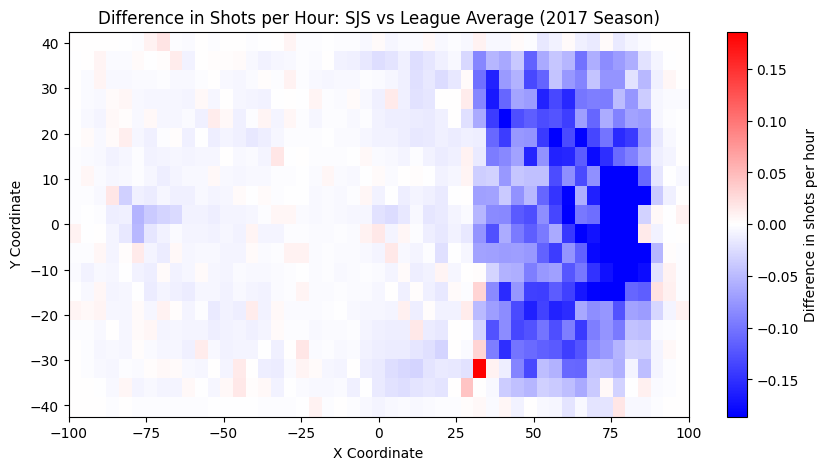

In [30]:
# Compute the difference between SJS and league averages
difference_hist = sjs_hist_per_hour - league_hist_per_hour

# Plot the difference histogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(x_edges, y_edges, difference_hist.T, shading='auto', cmap='bwr', vmin=-difference_hist.max(), vmax=difference_hist.max())
plt.colorbar(label='Difference in shots per hour')
plt.title('Difference in Shots per Hour: SJS vs League Average (2017 Season)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [31]:
def compute_histograms(data, season_year, team_dict):
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    hists = {}

    for team_abbreviation, full_name in team_dict.items():
        team_data = data[(data["season"] == season_year) & (data["byTeam"] == team_abbreviation)]
        team_data = team_data.dropna(subset=["coordinateX", "coordinateY"])
        n_game = team_data["gameId"].nunique()
        if n_game == 0:
            continue
        team_hist, _, _ = np.histogram2d(team_data["coordinateX"], team_data["coordinateY"], bins=[x_bins, y_bins])
        hists[team_abbreviation] = team_hist / n_game

    league_hist_shape = (len(x_bins) - 1, len(y_bins) - 1)
    league_hist = np.zeros(league_hist_shape)

    for team_hist in hists.values():
        league_hist += team_hist

    league_hist /= len(hists)
    for team_abbreviation in hists.keys():
        hists[team_abbreviation] -= league_hist

    return hists

In [32]:
data = pd.read_csv("../data/clean_data.csv")

In [33]:
import requests
response = requests.get('https://statsapi.web.nhl.com/api/v1/teams')
data = response.json()
team_dict = {team['abbreviation']: team['name'] for team in data['teams']}

# TEST

In [34]:
import plotly.graph_objects as go
from utils import unify_coordinates_referential

df = unify_coordinates_referential(data)
test = compute_histograms(df, 2017, team_dict)["NJD"]


fig = go.Figure(go.Heatmap(
    z=test,
    x=np.linspace(-100, 100, 50),
    y=np.linspace(-42, 42, 21),
    colorscale='Viridis'
))

fig.show()

AttributeError: 'dict' object has no attribute 'columns'

(49, 20)

# PYPLOT

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import plotly.figure_factory as ff
from utils import unify_coordinates_referential

def compute_histograms(data, season_year, team_dict):

    data = unify_coordinates_referential(data)
    
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    hists = {}
    teams_to_remove = []

    for team_abbreviation, full_name in team_dict.items():
        team_data = data[(data["season"] == season_year) & (data["byTeam"] == team_abbreviation)]
        team_data = team_data.dropna(subset=["coordinateX", "coordinateY"])
        n_game = team_data["gameId"].nunique()
        if n_game == 0:
            teams_to_remove.append(team_abbreviation)
            continue
        team_hist, _, _ = np.histogram2d(team_data["coordinateX"], team_data["coordinateY"], bins=[x_bins, y_bins])
        hists[team_abbreviation] = team_hist / n_game

    # Remove teams with no games
    for team in teams_to_remove:
        del team_dict[team]

    league_hist_shape = (len(x_bins) - 1, len(y_bins) - 1)
    league_hist = np.zeros(league_hist_shape)

    for team_hist in hists.values():
        league_hist += team_hist

    league_hist /= len(hists)
    for team_abbreviation in hists.keys():
        hists[team_abbreviation] -= league_hist

    return (hists, team_dict)

In [ ]:
data = pd.read_csv("clean_data.csv")
data = unify_coordinates_referential(data)

In [ ]:
def plot_team_vs_league_interactive_contour_adjusted(team_abbreviation, season_year):

    # Differential histograms
    difference_hists, new_team_dict = compute_histograms(data, season_year, team_dict)

    # Differential histogram for chosen team
    difference_team = difference_hists[team_abbreviation]
    team_full_name = new_team_dict.get(team_abbreviation, team_abbreviation)

    # Gaussian kernel smoothing
    smoothed_difference = gaussian_filter(difference_team, sigma=2.5)

    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    x_edges = (x_bins[:-1] + x_bins[1:]) / 2
    y_edges = (y_bins[:-1] + y_bins[1:]) / 2

    # Create a contour plot with red for positive values and blue for negative values
    # Create a contour plot with red for positive values and blue for negative values
    contour = go.Figure(data=go.Contour(z=smoothed_difference.T,
                                        x=x_edges,
                                        y=y_edges,
                                        colorscale=[(0, "blue"), (0.5, "white"), (1, "red")],
                                        zmid=0,
                                        ncontours=25))
                                        
    
    # Add title and labels with adjusted aspect ratio
    contour.update_layout(
        title=f'Average Shot Excess by Location: {team_full_name} vs League Average ({season_year})',
        xaxis_title="Coordinate X",
        yaxis_title="Coordinate Y",
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-98, 98]),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-40, 40]),
        width=1231,
        height=715
    )

    def image_to_base64(img_path):
        with open(img_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    hockey_rink_img_base64 = "data:image/png;base64," + image_to_base64("version_best.png")

    contour.add_layout_image(dict(
        source=hockey_rink_img_base64,
        xref="x",
        yref="y",
        x=-98,  # Adjust this to move the rink left or right
        y=40,  # Adjust this to move the rink up or down
        sizex=200,  # Size is made consistent with the contour plot range
        sizey=80,  # Size is kept the same
        opacity=0.7,
        layer="above")
    )

    return contour

import base64
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact_manual, fixed, IntSlider, Button
from ipywidgets import interact, fixed, IntSlider
# Change `interact` to `interact_manual` to add a "Run Interact" button
interact(
    plot_team_vs_league_interactive_contour_adjusted,
    team_abbreviation=fixed('TBL'),
    season_year=IntSlider(min=2018, max=2020, step=1, value=2018, description='Année:')
)

interactive(children=(IntSlider(value=2018, description='Année:', max=2020, min=2018), Output()), _dom_classes…

<function __main__.plot_team_vs_league_interactive_contour_adjusted(team_abbreviation, season_year)>

In [ ]:
from IPython.core.display import display
import base64
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, fixed, IntSlider, VBox

# Instead of using interact directly, capture the widget output
w = interact(
    plot_team_vs_league_interactive_contour_adjusted,
    team_abbreviation=fixed('TBL'),
    season_year=IntSlider(min=2018, max=2020, step=1, value=2018, description='Année:'),
    manual=True
)

# Ensure the display order is the widget followed by the figure
display(VBox([w.widget]))

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_2912\1199988280.py:1: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



interactive(children=(IntSlider(value=2018, description='Année:', max=2020, min=2018), Output()), _dom_classes…

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create the slider widget
season_year_slider = widgets.IntSlider(min=2018, max=2020, step=1, value=2018, description='Année:')

# Create an output widget to display the plot
output = widgets.Output()

# Display the slider
display(season_year_slider)

# Display the output below the slider
display(output)

# Define the update function
def update(change):
    output.clear_output(wait=True)  # Clear the previous plot
    with output:
        fig = plot_team_vs_league_interactive_contour_adjusted('TBL', change['new'])

# Attach the update function to the slider's value change event
season_year_slider.observe(update, names='value')

# Display the initial plot
update({'new': 2018})


IntSlider(value=2018, description='Année:', max=2020, min=2018)

Output()

interactive(children=(IntSlider(value=2018, description='Année:', max=2020, min=2018), Output()), _dom_classes…

<function __main__.plot_team_vs_league_interactive_contour_adjusted(team_abbreviation, season_year)>

In [ ]:
import base64

def interactive_plot_with_dropdown(season_year):
    fig = go.Figure()

    # Differential histograms
    difference_hists, new_team_dict = compute_histograms(data, season_year, team_dict)

    for team_abbreviation in new_team_dict.keys():
        # Differential histogram for chosen team
        difference_team = difference_hists[team_abbreviation]
        team_full_name = new_team_dict.get(team_abbreviation, team_abbreviation)

        # Gaussian kernel smoothing
        smoothed_difference = gaussian_filter(difference_team, sigma=2.5)
        x_bins = np.linspace(-100, 100, 50)
        y_bins = np.linspace(-42, 42, 21)
        x_edges = (x_bins[:-1] + x_bins[1:]) / 2
        y_edges = (y_bins[:-1] + y_bins[1:]) / 2

        # Add each team's contour to the figure, but hide all by default
        fig.add_trace(go.Contour(z=smoothed_difference.T,
                                 x=x_edges,
                                 y=y_edges,
                                 colorscale=[(0, "blue"), (0.5, "white"), (1, "red")],
                                 zmid=0,
                                 ncontours=25,
                                 visible=(team_abbreviation == 'NJD')))

    # Dropdown menu creation
    updatemenu = []
    buttons = []

    for i, team_abbreviation in enumerate(new_team_dict.keys()):
        visible = [False] * len(new_team_dict)
        visible[i] = True
        button = dict(label=new_team_dict[team_abbreviation],
                      method="update",
                      args=[{"visible": visible},
                            {"title": f"Excess moyen de tirs par emplacement: {new_team_dict[team_abbreviation]} vs Moyenne de la ligue ({season_year})"}])
        buttons.append(button)

    updatemenu.append(dict(buttons=buttons, direction="down",
                           showactive=True, x=0, xanchor="left", y=1.2, yanchor="top"))

    # Add the dropdown to the figure
    fig.update_layout(updatemenus=updatemenu)

    # Base layout settings that apply regardless of the team selected
    fig.update_layout(
        title=f"Excess moyen de tirs par emplacement: New Jersey Devils vs Moyenne de la ligue ({season_year})",
        xaxis_title="Coordonnée X",
        yaxis_title="Coordonnée Y",
        xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-98, 98]),
        yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='gray', range=[-40, 40]),
        title_x=0.5,
        title_y = 0.9,
        width=1207,
        height=715
    )

    def image_to_base64(img_path):
        with open(img_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    hockey_rink_img_base64 = "data:image/png;base64," + image_to_base64("version_best.png")

    hockey_rink_img = "version_best.png"
    fig.add_layout_image(dict(
        source=hockey_rink_img_base64,
        xref="x",
        yref="y",
        x=-98,
        y=40,
        sizex=200,
        sizey=80,
        opacity=0.7,
        layer="above")
    )

    return fig

# Display the contour plot with a dropdown menu for team selection
interactive_plot_with_dropdown(2017)

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go
import numpy as np
from scipy.ndimage import gaussian_filter

for season in range(2016, 2021):
    fig = interactive_plot_with_dropdown(season)
    pyo.plot(fig, filename=f'season_{season}.html')

# VERSION MATPLOTLIB

In [ ]:
def compute_histograms(data, season_year, team_dict):
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    hists = {}

    for team_abbreviation, full_name in team_dict.items():
        team_data = data[(data["season"] == season_year) & (data["byTeam"] == team_abbreviation)]
        team_data = team_data.dropna(subset=["coordinateX", "coordinateY"])
        n_game = team_data["gameId"].nunique()
        if n_game == 0:
            continue
        team_hist, _, _ = np.histogram2d(team_data["coordinateX"], team_data["coordinateY"], bins=[x_bins, y_bins])
        hists[team_abbreviation] = team_hist / n_game

    league_hist_shape = (len(x_bins) - 1, len(y_bins) - 1)
    league_hist = np.zeros(league_hist_shape)

    for team_hist in hists.values():
        league_hist += team_hist

    league_hist /= len(hists)
    for team_abbreviation in hists.keys():
        hists[team_abbreviation] -= league_hist

    return hists

No games found for team SEA. Skipping...


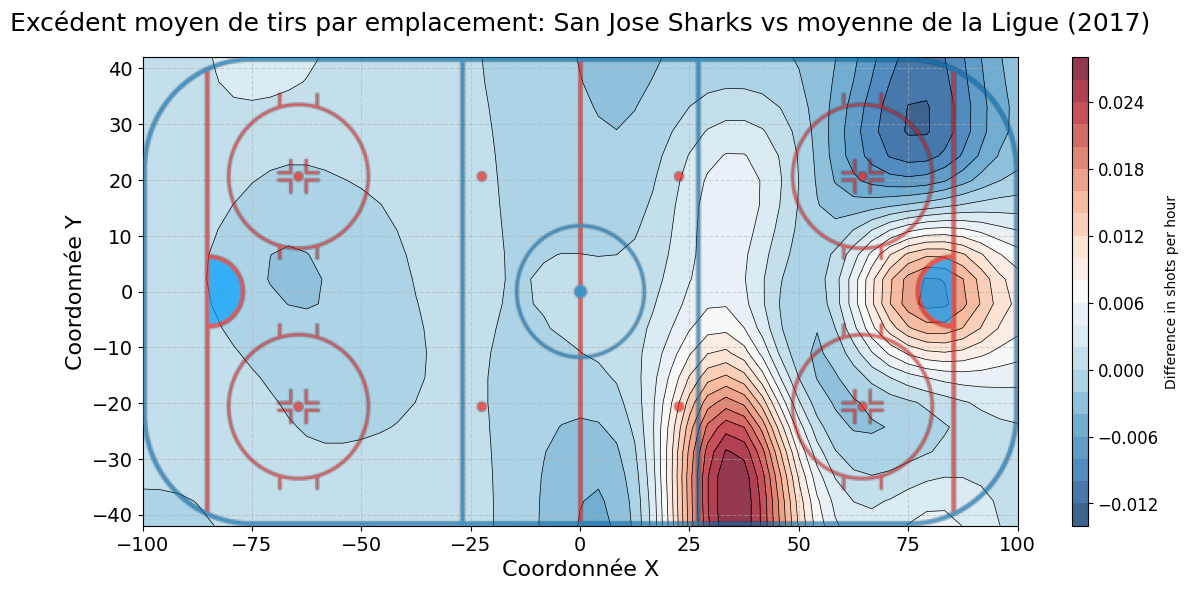

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from utils import unify_coordinates_referential
from matplotlib.colors import ListedColormap
import requests

def plot_team_vs_league(team_abbreviation, season_year):

    # Load data
    data = pd.read_csv("clean_data.csv")
    data = unify_coordinates_referential(data)

    # Differential histograms
    difference_hists = compute_histograms(data, season_year, team_dict)

    # Differential histogram for chosen team
    difference_team = difference_hists[team_abbreviation]
    team_full_name = team_dict.get(team_abbreviation, team_abbreviation)

    # Gaussian kernel smoothing
    smoothed_difference = gaussian_filter(difference_team, sigma=2.5)

    # Load the hockey rink image
    correct_hockey_court_img = plt.imread('version_best.png')

    default_cmap = plt.cm.RdBu_r
    colors = default_cmap(np.linspace(0, 1, 256))
    # Modify alpha values for a smoother transition around zero difference
    alpha_gradient = np.linspace(0.2, 1, 256)
    colors[:, 3] = alpha_gradient
    
    transparent_cmap_final = ListedColormap(colors)

    # Plot aesthetics and visualization without topography numbers
    plt.figure(figsize=(12, 6))

    # Create filled contours for gradient appearance as the background
    filled_contour = plt.contourf(smoothed_difference.T, levels=25, cmap=transparent_cmap_final, alpha=0.8, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    cbar = plt.colorbar(filled_contour, label='Difference in shots per hour', aspect=30)
    cbar.ax.tick_params(labelsize=12)

    # Add refined contour lines without topography numbers
    plt.contour(smoothed_difference.T, levels=25, colors='k', linestyles='solid', linewidths=0.5, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])

    # Overlay the hockey rink image on top of the visualization in the foreground with reduced opacity (alpha=0.7) and higher zorder
    plt.imshow(correct_hockey_court_img, aspect='auto', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], alpha=0.7, zorder=10)

    # Enhance title and labels to match desired aesthetic
    plt.title(f'Excédent moyen de tirs par emplacement: {team_full_name} vs moyenne de la Ligue ({season_year})', fontsize=18, y=1.04)
    plt.xlabel('Coordonnée X', fontsize=16)
    plt.ylabel('Coordonnée Y', fontsize=16)
    plt.xticks(fontsize=14,)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Example usage:
plot_team_vs_league('SJS', 2017)

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from utils import unify_coordinates_referential

from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColorBar, LinearColorMapper, ColumnDataSource, CustomJS, Select
from bokeh.layouts import column
from bokeh.palettes import RdBu as palette

def compute_differences(data, season_year, team_dict):
    x_bins = np.linspace(-100, 100, 50)
    y_bins = np.linspace(-42, 42, 21)
    smoothed_diffs = {}
    hists = {}
    teams_to_remove = []  # List to store teams that have n_game == 0
    
    for team_abbreviation, full_name in team_dict.items():
        team_data = data[(data["season"] == season_year) & (data["byTeam"] == team_abbreviation)]
        team_data = team_data.dropna(subset=["coordinateX", "coordinateY"])
        n_game = team_data["gameId"].nunique()
        
        if n_game == 0:
            teams_to_remove.append(team_abbreviation)
            continue
        
        team_hist, _, _ = np.histogram2d(team_data["coordinateX"], team_data["coordinateY"], bins=[x_bins, y_bins])
        hists[team_abbreviation] = team_hist / n_game

    # Remove teams with n_game == 0 from the team_dict
    for team in teams_to_remove:
        del team_dict[team]

    league_hist_shape = (len(x_bins) - 1, len(y_bins) - 1)
    league_hist = np.zeros(league_hist_shape)

    for team_hist in hists.values():
        league_hist += team_hist

    league_hist /= len(hists)
    
    for team_abbreviation, team_hist in hists.items():
        difference = team_hist - league_hist
        smoothed_diff = gaussian_filter(difference, sigma=2.5)
        smoothed_diffs[team_abbreviation] = smoothed_diff

    return smoothed_diffs, team_dict

In [ ]:
def create_interactive_plot(data, season_year, team_dict):
    
    output_file("interactive_plot.html")
    
    all_data = {}
    smoothed_diffs, team_dict = compute_differences(data, season_year, team_dict)  # Get the modified team_dict
    for team in team_dict.keys():
        all_data[team] = smoothed_diffs[team]

    # Assuming you have x_edges and y_edges from the previous computations
    x_range = (x_edges[0], x_edges[-1])
    y_range = (y_edges[0], y_edges[-1])

    initial_team = list(team_dict.keys())[0]
    source = ColumnDataSource(data=dict(image=[all_data[initial_team]], x=[x_range[0]], y=[y_range[0]], dw=[x_range[1] - x_range[0]], dh=[y_range[1] - y_range[0]]))

    color_mapper = LinearColorMapper(palette=palette[11], low=-1, high=1)

    p = figure(x_range=x_range, y_range=y_range, width=800, height=400)
    p.image(source=source, image='image', x='x', y='y', dw='dw', dh='dh', color_mapper=color_mapper)

    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title="Difference in shots per hour")
    p.add_layout(color_bar, 'right')

    menu = list(team_dict.values())
    select = Select(title="Équipe:", value=menu[0], options=menu)

    callback = CustomJS(args=dict(source=source, all_data=all_data), code="""
        const selected_team = cb_obj.value;
        const new_data = all_data[selected_team];
        source.data['image'] = [new_data];
        source.change.emit();
    """)
    select.js_on_change('value', callback)

    layout = column(select, p)
    show(layout)

# Load and process data
data = pd.read_csv("clean_data.csv")
data = unify_coordinates_referential(data)
create_interactive_plot(data, 2017, team_dict)

In [ ]:
from bokeh.plotting import figure, show

p = figure()
p.circle([1, 2, 3, 4, 5], [2, 5, 8, 2, 7], size=10, color="navy", alpha=0.5)
show(p)
